Constructiong distribution for lambda_s= 0
0 / 1000 trials done.


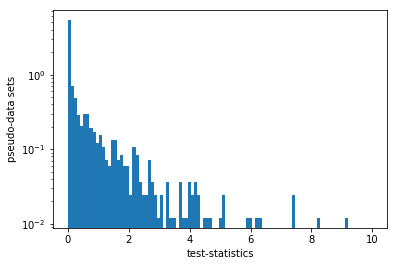

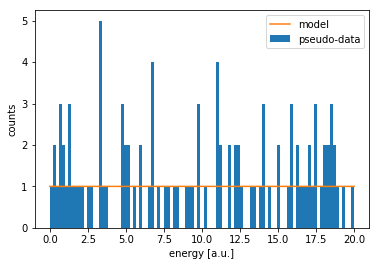

H0: lambda_s =  0 p-value =  0.629


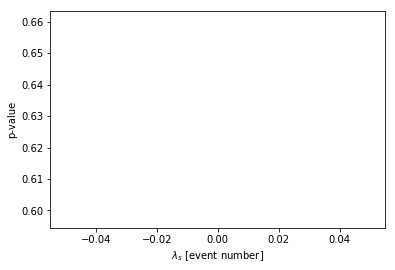

In [1]:
'''
Statistical and Machine Learning Methods in Particle and Astrophysics

TUM - summer term 2019
M. Agostini <matteo.agostini@tum.de> and Hans Niederhausen@tum.de <hans.niederhausen@tum.de>

Ex 1, conceptual steps
    1) build a model 
    2) build a data set by sampling the model and storing the events in a hist
    3) conmpute test statistic as difference of negative log likelihoods
    4) repeat steps 1-2-3 and build probability distribution of the test statistic for a specifcic test
    5) repeate step 4 for different values of the parameter of interest lambda_s and create the 
       probability distribution of the test statistic expected under different tests
    6) compute p-value of an specific data set ("observed data") as a functio of the value of lamnda_s
       used in the test
'''

import math 
import numpy as np
import pylab as pl
from scipy import optimize
from scipy import stats
from scipy.stats import norm
from scipy.integrate import simps
from scipy.interpolate import interp1d

#
# define model as a function. The function works on a vector of samples x
#
def PDF_Energy(x, lambda_s, lambda_b, model_fixed_par, check_normalization = False): 
    
    # retrieve parameters
    gaussian_mean = model_fixed_par["gaussian_mean"]
    gaussian_sigma = model_fixed_par["gaussian_sigma"]
    x_min = model_fixed_par["x_min"]
    x_max = model_fixed_par["x_max"]
    
    # first, we evaluate the normal/truncated normal distribution.
    # if necessary, we correctly normalize to unity. this is useful if the guassian 
    # is close to the borders
    norm_pdf_values = norm.pdf(x, gaussian_mean, gaussian_sigma)

    if (check_normalization):
        # compute normalization of the pdf
        normalization =  simps (norm_pdf_values, x, axis = 0)
        # check if pdf integral is close enough to 1
        if (np.fabs(normalization - 1.0) > 1E-8 ): 
            norm_pdf_values /= normalization
    

    # define actual probability function: sum of gaussian + uniform
    pdf = (1./(lambda_s+lambda_b)) * \
          (lambda_b * 1./(x_max - x_min) + lambda_s * norm_pdf_values )

    # check that the probability is tested within its defined range
    x_underflow = np.where(x < x_min)[0]
    x_overflow  = np.where(x > x_max)[0]
    x_out_of_range = x_underflow + x_overflow
    if (len(x_out_of_range) != 0):
        print('error: energy of an event out of range')
        exit()
  
    return pdf

#
# Define function to 
# 1) sample a number of events given the summed expectation and 
# 2) to sample for each event an energy given the energy pdf define above.
#
def GeneratePseudoData(lambda_s, lambda_b, model_fixed_par):
    
    # retrieve parameters
    gaussian_mean = model_fixed_par["gaussian_mean"]
    gaussian_sigma = model_fixed_par["gaussian_sigma"]
    x_min = model_fixed_par["x_min"]
    x_max = model_fixed_par["x_max"]

    # array of values used to interpolate the pdf and cdf
    x = np.linspace(x_min, x_max, 10001)

    # build energy pdf 
    pdf = PDF_Energy(x, lambda_s = lambda_s, lambda_b = lambda_b, \
                     model_fixed_par = model_fixed_par)
    
    # sample the size of the pseudodata given an expectation
    size = stats.poisson.rvs(mu = lambda_s + lambda_b)
    
    # create vector of random samples betwen 0 and 1
    samples = np.random.uniform(0.0, 1.0, int(size))
    
    # compute cumulative distribution of the pdf
    cdf = np.cumsum(pdf); cdf /= max(cdf)
    
    # compute inverse of the cumulative over
    inverse_cdf = interp1d(cdf, x, bounds_error = False, fill_value = 0)
    
    # assign values to the random samples
    return inverse_cdf(samples)

#
# Define negative log likelihood function as sum of probabilities. The nll
# is computed for a given data set regarded as fixed and minimized against 
# the parameters of interest and nuisance parameters, i.e. lambda_s and lambda_b 
#
def NLL (data, lambda_s_tested, lambda_b_tested, model_fixed_par):
    
    # start by computing the extended term, i.e. the Poisson probability 
    # of observing N counts given an expectation of lambda)
    NLL_extended_term = - stats.poisson.logpmf(k = data.size, \
                                               mu = lambda_s_tested + lambda_b_tested)
 
    # now compute the probability for the energy of each event given the model and
    # sum the logs. The implementation based on a loop would be
    #
    #for x in data: 
    #    NLL_energy -= math.log(
    #        PDF_Energy(x, lambda_s, lambda_b, gaussian_mean, gaussian_sigma, \
    #                   x_min, x_max, check_normalization=False) )
    #
    # however this is not efficient and can be reimplemented using numpy 
    #
    NLL_energy = -np.sum( np.log(PDF_Energy(data, lambda_s_tested, lambda_b_tested, \
                                            model_fixed_par = model_fixed_par)))
    
    return NLL_extended_term + NLL_energy

#
# Define test statistic. This test statistic is the ratio between the NLL 
# minimum in the restrected parameter space of the null hypothesis vs the 
# NLL absolute mimimum
#
def TestStatistic (data, lambda_s_tested, model_fixed_par):

    # find absolute minimimum of likelihood function as a function of lambda_s and lambda_b, 
    # i.e. the parameter of interest (POI) and a nuisance parameter. 
    # The minimization performed through optimize.minimize requires to parse a function whose 
    # first argument is a vector of the parameters to vary
    def fmin_full_space(par): 
        return NLL(data = data, lambda_s_tested = par[1], lambda_b_tested = par[0], \
                   model_fixed_par = model_fixed_par)

    NLL_abs_min = optimize.minimize(fmin_full_space, (100,lambda_s_tested), \
                                    bounds=((0, None), (0, None)), \
                                    options={'disp': False})
        
    # now find minimum in the restrectited parameter space
    def fmin_restricted_space(par): 
        return NLL(data = data, lambda_s_tested = lambda_s_tested, lambda_b_tested = par[0], \
                   model_fixed_par = model_fixed_par)

    NLL_res_min = optimize.minimize(fmin_restricted_space, (100), \
                                    bounds=((0, None),), \
                                    options={'disp': False})

    return 2*(NLL_res_min.fun - NLL_abs_min.fun)


#
# Calculate test statistics probability distributions assuming different values
# for lambda_s and lambda_b
#
def CalculateTestDist(n_datasets, lambda_s, lambda_b, model_fixed_par, plot = True):
             
    # loop over multiple pseudo-data sets and store info in test_stastic
    test_statistic_values =[]

    # loop over the pseudo-data sets
    for i in np.arange(n_datasets):
        
        # print counter 
        if (i%1000)==0: print(i,"/",n_datasets,"trials done.")

        # generate pseudo-data
        pseudo_data = GeneratePseudoData(lambda_s = lambda_s, lambda_b = lambda_b, \
                                         model_fixed_par = model_fixed_par)
        
        # compute test statistic
        test_statistic = TestStatistic(data = pseudo_data, lambda_s_tested = lambda_s, \
                                       model_fixed_par = model_fixed_par)   
        
        test_statistic_values.append(test_statistic)
          
    test_statistic_values = np.array(test_statistic_values)
    
    # create and plot hist of the test stastic
    if (plot):
        pl.hist(test_statistic_values, bins=np.linspace(0,10,100), log=True, normed=True)
        pl.xlabel('test-statistics')
        pl.ylabel('pseudo-data sets')
        pl.show()
    
    return test_statistic_values


#
# Calculate test statistic distributions for a vector of lambda_s values
#
def CalculateTestDistScan(n_datasets, lambda_s_vector,  lambda_b, model_fixed_par):                     
    
    test_statistic_dist = []
    for lambda_s in lambda_s_vector:
        print('Constructiong distribution for lambda_s=', lambda_s)
        test_statistic_dist.append(CalculateTestDist(n_datasets, lambda_s, lambda_b,\
                                                     model_fixed_par = model_fixed_par))
        
    return test_statistic_dist


#
# Calculate p-value for a specific data set
#
def CalculatePValues(test_statistic_dist, lambda_s_vector, lambda_b, lambda_s, model_fixed_par):
   
    # Generate special set of pseudo data and analyze it as if it were the observed data
    obs_data = GeneratePseudoData(lambda_s = lambda_s, lambda_b = lambda_b, \
                                  model_fixed_par = model_fixed_par)
    
    # plot the pseudo-data as histogram
    x_min = model_fixed_par["x_min"]
    x_max = model_fixed_par["x_max"]

    bins = np.linspace(x_min, x_max, 100)
    pl.hist(obs_data, bins=bins, normed=False, label = 'pseudo-data')
    pl.xlabel('energy [a.u.]')
    pl.ylabel('counts')
    
    # plot the model 
    x = np.linspace(x_min, x_max, 10001)

    # build energy pdf 
    pdf_energy = PDF_Energy(x, lambda_s = lambda_s, lambda_b = lambda_b, \
                     model_fixed_par = model_fixed_par)

    pl.plot(x, pdf_energy * (lambda_s + lambda_b) * (x_max-x_min) / bins.size, label = 'model')
    pl.legend(loc='best')
    pl.show()

    # compute value of the test statistic for the obseved data over a vector of lambda_s values
    # vector to store test statistic values
    test_statistic_values = [] 
    # trasform the argument into a vector even if it is a single object
    lambda_s_vector = np.array(lambda_s_vector) 
    for lambda_s in lambda_s_vector:
        tested_value = TestStatistic(data = obs_data, lambda_s_tested = lambda_s, \
                                     model_fixed_par = model_fixed_par)
        
        test_statistic_values.append(tested_value)

    # compute p-values for the observed data given the probability distribution parsed to the
    # functoin
    p_value = []
    for index, item in enumerate(lambda_s_vector):
        more_extreme_values = (test_statistic_dist[index]>test_statistic_values[index]).sum()
        p_value.append(more_extreme_values/len(test_statistic_dist[index]))
        print("H0: lambda_s = ", lambda_s_vector[index], "p-value = ", p_value[index])
    
    pl.plot(lambda_s_vector,p_value)
    pl.xlabel('$\lambda_s$ [event number]')
    pl.ylabel('p-value')
    pl.show()
    
    return

if __name__ == "__main__":
     
    # define model parameters
    model_fixed_par = {
        "gaussian_mean" : 10.0,
        "gaussian_sigma" : 1.0,
        "x_min" : 0.0,
        "x_max" : 20.0
    }
    # define seed of the random number generator
    np.random.seed(0)
    # define number of pseudodata sets used to build the probability distributions
    # of the test statistics
    n_datasets=1000
    # define tru value of lambda injected in the anlaysis data set (what in an experiment
    # is commonly called the observbed data est)
    lambda_b_true = 100
    
    # compute test statistic distribution for lambda_s_true = 0
    test_statistic_dist = CalculateTestDistScan(n_datasets = n_datasets, \
                                                lambda_s_vector = (0,),\
                                                lambda_b = lambda_b_true, \
                                                model_fixed_par = model_fixed_par)
    
    # generate observed data and compute p-value for lambda_s_true, i.e. the significance
    # with which we reject the null hypothesis lambda_s_true  = 0
    CalculatePValues(test_statistic_dist = test_statistic_dist, lambda_s_vector = (0,),\
                     lambda_b = 100, lambda_s = 0, model_fixed_par = model_fixed_par)
    


Constructiong distribution for lambda_s= 0.0
0 / 1000 trials done.


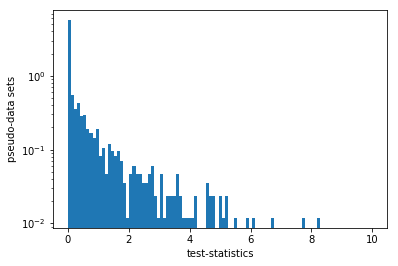

Constructiong distribution for lambda_s= 1.0
0 / 1000 trials done.


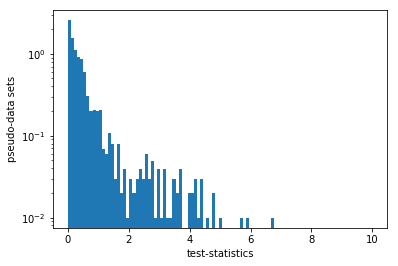

Constructiong distribution for lambda_s= 2.0
0 / 1000 trials done.


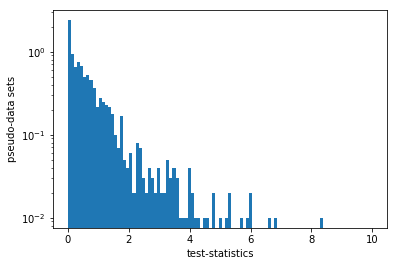

Constructiong distribution for lambda_s= 3.0
0 / 1000 trials done.


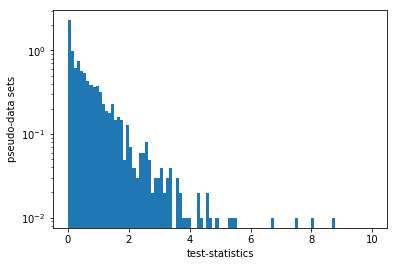

Constructiong distribution for lambda_s= 4.0
0 / 1000 trials done.


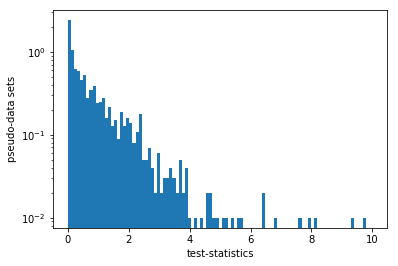

Constructiong distribution for lambda_s= 5.0
0 / 1000 trials done.


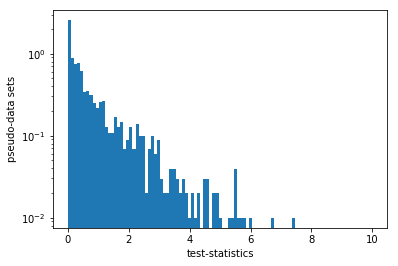

Constructiong distribution for lambda_s= 6.0
0 / 1000 trials done.


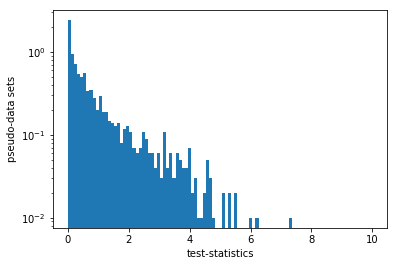

Constructiong distribution for lambda_s= 7.0
0 / 1000 trials done.


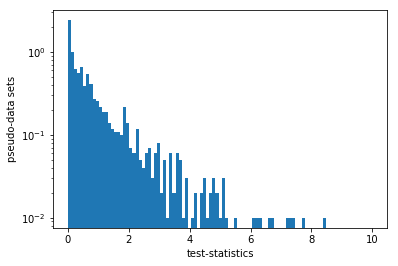

Constructiong distribution for lambda_s= 8.0
0 / 1000 trials done.


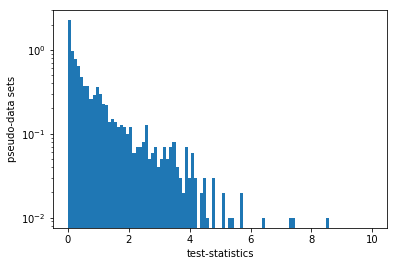

Constructiong distribution for lambda_s= 9.0
0 / 1000 trials done.


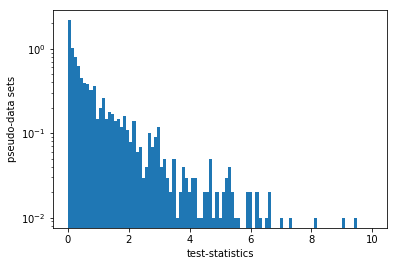

Constructiong distribution for lambda_s= 10.0
0 / 1000 trials done.


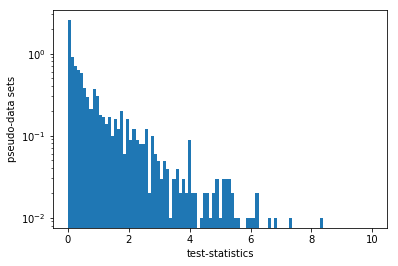

Constructiong distribution for lambda_s= 11.0
0 / 1000 trials done.


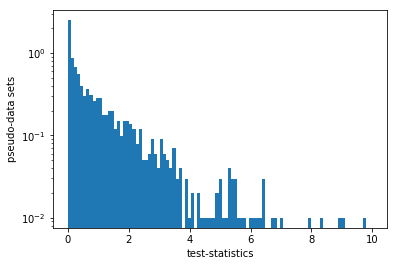

Constructiong distribution for lambda_s= 12.0
0 / 1000 trials done.


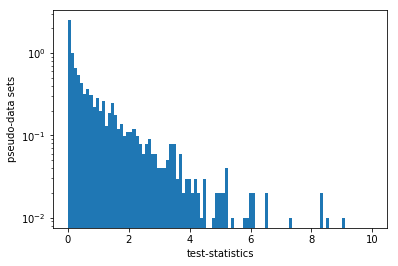

Constructiong distribution for lambda_s= 13.0
0 / 1000 trials done.


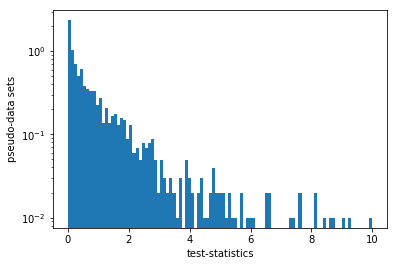

Constructiong distribution for lambda_s= 14.0
0 / 1000 trials done.


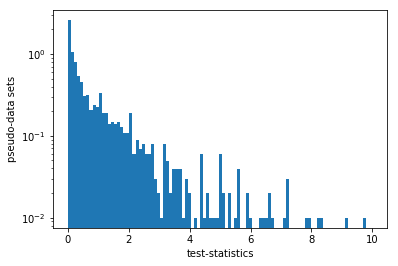

Constructiong distribution for lambda_s= 15.0
0 / 1000 trials done.


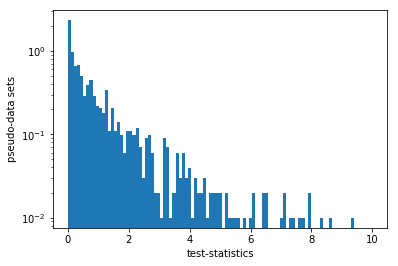

Constructiong distribution for lambda_s= 16.0
0 / 1000 trials done.


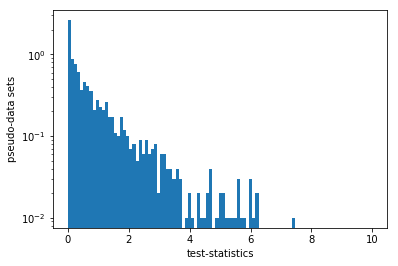

Constructiong distribution for lambda_s= 17.0
0 / 1000 trials done.


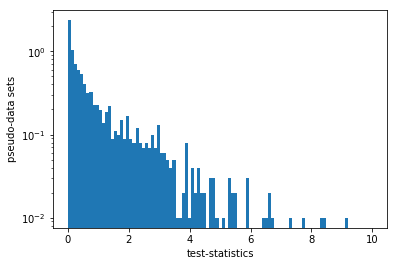

Constructiong distribution for lambda_s= 18.0
0 / 1000 trials done.


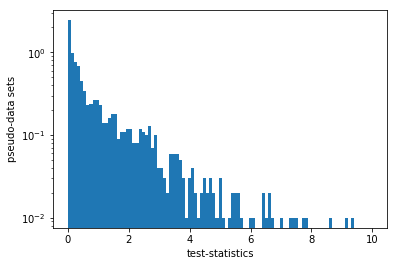

Constructiong distribution for lambda_s= 19.0
0 / 1000 trials done.


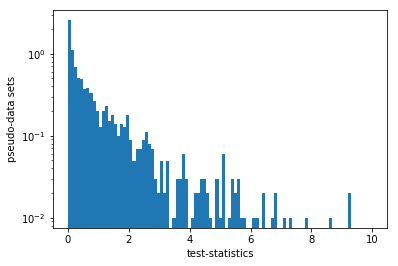

Constructiong distribution for lambda_s= 20.0
0 / 1000 trials done.


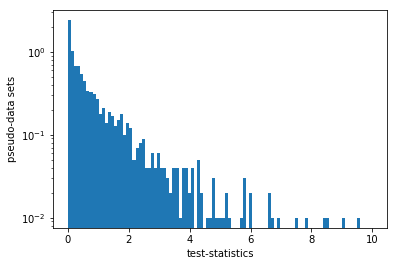

In [2]:
    # compute test statistic distribution for lambda_s_true from 0 to 20
    lambda_s_vector = np.linspace(0,20,21)
    test_statistic_dist = CalculateTestDistScan(n_datasets = n_datasets, \
                                                lambda_s_vector = lambda_s_vector,\
                                                lambda_b = lambda_b_true, \
                                                model_fixed_par = model_fixed_par)
    


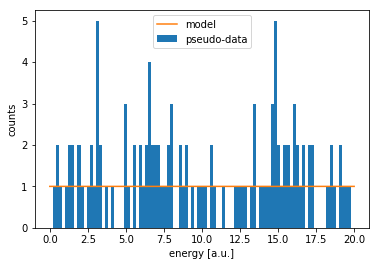

H0: lambda_s =  0.0 p-value =  0.98
H0: lambda_s =  1.0 p-value =  0.21
H0: lambda_s =  2.0 p-value =  0.154
H0: lambda_s =  3.0 p-value =  0.073
H0: lambda_s =  4.0 p-value =  0.051
H0: lambda_s =  5.0 p-value =  0.031
H0: lambda_s =  6.0 p-value =  0.012
H0: lambda_s =  7.0 p-value =  0.01
H0: lambda_s =  8.0 p-value =  0.003
H0: lambda_s =  9.0 p-value =  0.005
H0: lambda_s =  10.0 p-value =  0.0
H0: lambda_s =  11.0 p-value =  0.004
H0: lambda_s =  12.0 p-value =  0.002
H0: lambda_s =  13.0 p-value =  0.0
H0: lambda_s =  14.0 p-value =  0.0
H0: lambda_s =  15.0 p-value =  0.001
H0: lambda_s =  16.0 p-value =  0.0
H0: lambda_s =  17.0 p-value =  0.0
H0: lambda_s =  18.0 p-value =  0.0
H0: lambda_s =  19.0 p-value =  0.0
H0: lambda_s =  20.0 p-value =  0.0


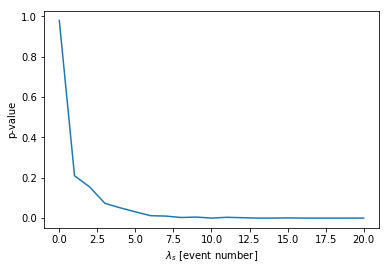

In [3]:
    CalculatePValues(test_statistic_dist = test_statistic_dist, lambda_s_vector = lambda_s_vector,\
                     lambda_b = 100, lambda_s = 0, \
                     model_fixed_par = model_fixed_par)